# Topic Modeling

Goals:
- Understand Topic Modeling
- Learn Latent Dirichlet Allocation
- Implement LDA
- Understand Non-Negative Matrix Factorization
- Implement NMF
- Apply LDA and NMF with a project

Topic Modeling allows for us to efficiently analyze large volumes of text by clustering documents into topics. A large amount of text data is **unlabeled** meaning we won't be able to apply our previous supervised learning approaches to create machine learning models for the data.

If we have unlabeled data, then we can attempt to "discover" labels. In the case of text data, this means attempting to discover clusters of documents, grouped together by topic.

A very important idea to keep in mind here is that we don't know the "correct" topic or "right answer". All we know is that the documents clustered together share similar topic ideas. It is up to user to identify what these topics represent.

We will begin by examining how Latent Dirichlet Allocation can attempt to discover topics for a corpus of documents.

## Latent Dirichlet Allocation

Johan Peter Gustave Lejeune Dirihlet was a German mathematician in 1800s who contributed widely to the field of modern mathematics. There is a probability distribution named after him "Dirichlet Distribution". Latent Dirichlet Allocation is based off this probability distribution. In 2003 LDA was first published as graphical model for topic discovery in _Journal of Machine Learning Research_ by David Blei, Andrew Ng and Michael I. Jordan.

There are 2 main assumptions of LDA for Topic Modeling:
- Documents with similar topics use similar groups off words.
- Latent topics can then be found by searching for groups of words that frequently occur together in documents accross the corpus.

We can think of this 2 assumptions mathematically as following:
- Documents are probability distributions over latent topics.
- Topics themselves are probability distribution over words.

LDA represents documents as mixtures of topics that spit out words with certain probabilities. It assumes that documents are produced in the following fashion:
- Decide on the number of words N the document will have.
- Choose a topic mixture for the document (according to Dirichlet distribution over fixed set of $K$ topics). e.g. 60% business, 20% politics, 10% food.

Generate each word in the document by:
- First picking topic according to the multinomial distribution that you sampled previously (60% business, 20% politics, 10% food).
- Using the topic to generate the word itself (according to the topic's multinomial distribution). For example, if we slected the food topic, we might generate the word "apple" with 60% probability, "home" with 30% probability and so on.
- Assuming this generative model for collection of documents, LDA then tries to backtrack from the documents to find set of topics that are likely to have generated collection.

Now imgaine we have a set of documents. We've chosen some fixed number of $K$ topics to discover, and want to use LDA to learn the topic representation of each document and the words associated to each topic. The user should also define how many topics should be discovered. Then we should go through each document, and randomly assign each word in the document to one of the $K$ topics. This random assignment already gives you both topic representations of all the documents and word distributions of all the topics (note, these initial random topics won't make sense).

Now we iterate over every word in every document to improve these topics. For every word in every document and for each topic $t$ we calculate:

- $p(topic\ t \ |\ document\ d) =$ the proportion of words in document $d$ that are currently assigned to topic $t$.
- $p(word\ w \ |\ topic\ t) = $ the proportion of assinments to topic $t$ over all documents that come from this word $w$.
- Reassing $w$ a new topic, where we choose topic $t$ with probability $p(topic\ t\ |\ document\ d) \cdot p(word\ w\ |\ topic\ t)$. This is essentially the probability that topic generated word $w$.
- After repeating the previous step a large number of times, we eventually reach a roughly steady state where the assignments are acceptable.

At the end we have each document assigned to a topic. We also can search for the words that have the highest probability of being assigned to a topic. As the final we end upt with an output such as:
- Document assigned to Topic #4
- Most common words (highest probability) for Topic #4: `['cat','vet','birds','dog',...,'food','home]`.

**It is up to the user to interpret these topics. The user themselves should define what topics are.**

In [1]:
import pandas as pd

In [2]:
npr = pd.read_csv('npr.csv')

This dataset is a 12 thousand articles. And each row represent full text of the article. As you may see we have only article but nothing like labels.

In [3]:
npr.head()

,Article
0,"In the Washington of 2016, even when the polic..."
1,Donald Trump has used Twitter — his prefe...
2,Donald Trump is unabashedly praising Russian...
3,"Updated at 2:50 p. m. ET, Russian President Vl..."
4,"From photography, illustration and video, to d..."


Let's view one of the articles.

In [5]:
npr['Article'][0]

'In the Washington of 2016, even when the policy can be bipartisan, the politics cannot. And in that sense, this year shows little sign of ending on Dec. 31. When President Obama moved to sanction Russia over its alleged interference in the U. S. election just concluded, some Republicans who had long called for similar or more severe measures could scarcely bring themselves to approve. House Speaker Paul Ryan called the Obama measures ”appropriate” but also ”overdue” and ”a prime example of this administration’s ineffective foreign policy that has left America weaker in the eyes of the world.” Other GOP leaders sounded much the same theme. ”[We have] been urging President Obama for years to take strong action to deter Russia’s worldwide aggression, including its   operations,” wrote Rep. Devin Nunes,  . chairman of the House Intelligence Committee. ”Now with just a few weeks left in office, the president has suddenly decided that some stronger measures are indeed warranted.” Appearing 

Let's check length of the actual dataset.

In [6]:
len(npr)

11992

So we don't know yet which topics this articles belong to. So we're going to try to attempt to figure this out and assign a topic to each of these articles.

## Preprocessing

Before performing LDA let's do a little bit of preprocessing.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

Here we need to specify several parameters. 
- `max_df` is when you're building out the vocabulary we're going to ignore certain terms that have really high document frequency. The number between 0 and 1 should be typed. Here we will discard words that show up in 90% of the documents.
- `min_df` is a minimum document frequency. The words which show up a minimum amount of times. The value between 0 and 1 can be used as well as an integer. What this means is that 2 is passed as the value for this paramenter, the word will be vectorized if it has to show up at least in 2 documents.
- `stop_words` is for removing stop words.

In [9]:
cv = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')

Let's fit it to the articles. I will not od any train test split, because it is unsupervised learning.

In [10]:
dtm = cv.fit_transform(npr['Article'])

Now if we check out our matrix, we can tell that is sparse.

In [11]:
dtm

<11992x54777 sparse matrix of type '<class 'numpy.int64'>'
	with 3033388 stored elements in Compressed Sparse Row format>

## LDA

Now we need to perform Latent Dirichlet Allocation.

In [12]:
from sklearn.decomposition import LatentDirichletAllocation

Here `n_components` is the number of topics that should be returned. Assigning this number is really depends on domain expertise and familiarity with the content of the data that is been explored.

In [13]:
LDA = LatentDirichletAllocation(n_components=7, random_state=42)

In [14]:
LDA.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=7, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

There are 3 steps left to do: 
- The 1st one is to grab the vocabulary of words.
- Grab the topics.
- Grab the highest probability per topic.

We can see that the length represents the size of the matrix

In [16]:
# Grab the vocabulary of words
print(len(cv.get_feature_names()))

54777


In [17]:
type(cv.get_feature_names())

list

In [19]:
print(cv.get_feature_names()[50000]), print(cv.get_feature_names()[41000])

transcribe
reproductive


(None, None)

In [21]:
import random

random_word_id = random.randint(0, 54777)

cv.get_feature_names()[random_word_id]

'champagne'

So what we can see there is that there are 7 topics (refering to `n_components`) and each topic is a `numpy` array

In [22]:
# Grab the topic from LDA

print(len(LDA.components_)), print(type(LDA.components_))

7
<class 'numpy.ndarray'>


(None, None)

In [23]:
LDA.components_.shape

(7, 54777)

In [24]:
LDA.components_

array([[8.64332806e+00, 2.38014333e+03, 1.42900522e-01, ...,
        1.43006821e-01, 1.42902042e-01, 1.42861626e-01],
       [2.76191749e+01, 5.36394437e+02, 1.42857148e-01, ...,
        1.42861973e-01, 1.42857147e-01, 1.42906875e-01],
       [7.22783888e+00, 8.24033986e+02, 1.42857148e-01, ...,
        6.14236247e+00, 2.14061364e+00, 1.42923753e-01],
       ...,
       [3.11488651e+00, 3.50409655e+02, 1.42857147e-01, ...,
        1.42859912e-01, 1.42857146e-01, 1.42866614e-01],
       [4.61486388e+01, 5.14408600e+01, 3.14281373e+00, ...,
        1.43107628e-01, 1.43902481e-01, 2.14271779e+00],
       [4.93991422e-01, 4.18841042e+02, 1.42857151e-01, ...,
        1.42857146e-01, 1.43760101e-01, 1.42866201e-01]])

In [25]:
single_topic = LDA.components_[0]

Here what `argsort()` does is that it returns the index positions that would sort this array.

In [26]:
single_topic.argsort()

array([ 2475, 18302, 35285, ..., 22673, 42561, 42993], dtype=int64)

Let's provide an example of what this `argsort()` actually does.

In [27]:
import numpy as np

In [28]:
arr = np.array([10,200,1])

In [29]:
arr

array([ 10, 200,   1])

So there's an index position that will sort this array from the smallest value to the biggest one.

In [30]:
arr.argsort()

array([2, 0, 1], dtype=int64)

So with `argsort()` we can get positions of the highest probabiolity for a single topic. Let's grab the top 10 words for this topic.

In [31]:
# top 10 values. the 10 greatest values. grabbing the last 10 numbers of argsort
single_topic.argsort()[-10:]

array([33390, 36310, 21228, 10425, 31464,  8149, 36283, 22673, 42561,
       42993], dtype=int64)

In [32]:
top_ten_wrods = single_topic.argsort()[-10:]

So from the output we can tell that there are government articles or healthcare issue articles.

In [33]:
for index in top_ten_wrods:
    print(cv.get_feature_names()[index])

new
percent
government
company
million
care
people
health
said
says


In [35]:
top_twenty_wrods = single_topic.argsort()[-20:]

These words have high probabilities of showing up in this particular single topic.

In [36]:
for index in top_twenty_wrods:
    print(cv.get_feature_names()[index])

president
state
tax
insurance
trump
companies
money
year
federal
000
new
percent
government
company
million
care
people
health
said
says


Let's set up a loop that prints top 15 words for each of 7 topics.

In [37]:
# Grab the highest probability per topic

for i, topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{i}')
    print([cv.get_feature_names()[index] for index in topic.argsort()[-15:]])
    print('\n')
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['companies', 'money', 'year', 'federal', '000', 'new', 'percent', 'government', 'company', 'million', 'care', 'people', 'health', 'said', 'says']




THE TOP 15 WORDS FOR TOPIC #1
['military', 'house', 'security', 'russia', 'government', 'npr', 'reports', 'says', 'news', 'people', 'told', 'police', 'president', 'trump', 'said']




THE TOP 15 WORDS FOR TOPIC #2
['way', 'world', 'family', 'home', 'day', 'time', 'water', 'city', 'new', 'years', 'food', 'just', 'people', 'like', 'says']




THE TOP 15 WORDS FOR TOPIC #3
['time', 'new', 'don', 'years', 'medical', 'disease', 'patients', 'just', 'children', 'study', 'like', 'women', 'health', 'people', 'says']




THE TOP 15 WORDS FOR TOPIC #4
['voters', 'vote', 'election', 'party', 'new', 'obama', 'court', 'republican', 'campaign', 'people', 'state', 'president', 'clinton', 'said', 'trump']




THE TOP 15 WORDS FOR TOPIC #5
['years', 'going', 've', 'life', 'don', 'new', 'way', 'music', 'really', 'time', 'know'

Now what is important to do is to assing this topic numbers to the original articles.

In [38]:
%%time
topic_results = LDA.transform(dtm)

Wall time: 9.84 s


Now if we take a look at the `topic_results`, it is an array.

In [39]:
topic_results

array([[1.61040465e-02, 6.83341493e-01, 2.25376318e-04, ...,
        2.99652737e-01, 2.25479379e-04, 2.25497980e-04],
       [3.63424997e-02, 8.86130697e-01, 4.40751747e-04, ...,
        7.57636804e-02, 4.40866779e-04, 4.40835574e-04],
       [3.28569485e-04, 6.96344889e-01, 3.28302105e-04, ...,
        3.02012902e-01, 3.28724083e-04, 3.28352652e-04],
       ...,
       [1.44467964e-02, 1.60696622e-01, 1.73678310e-01, ...,
        2.24636569e-02, 3.98728349e-04, 3.98359730e-04],
       [4.33560738e-04, 3.53196803e-02, 4.33022554e-04, ...,
        9.62512640e-01, 4.33971991e-04, 4.33490254e-04],
       [3.98777533e-01, 2.54376049e-04, 3.59290659e-01, ...,
        2.40914375e-01, 2.54445555e-04, 2.54253739e-04]])

In [40]:
topic_results.shape

(11992, 7)

These are probabilities of a document belonging to the particular topic.

In [42]:
topic_results[0]

array([1.61040465e-02, 6.83341493e-01, 2.25376318e-04, 2.25369288e-04,
       2.99652737e-01, 2.25479379e-04, 2.25497980e-04])

So the article number 0 have the highest probability of belonging to the topic number 1

In [44]:
topic_results[0].round(2)

array([0.02, 0.68, 0.  , 0.  , 0.3 , 0.  , 0.  ])

Let's connect that with our original `DataFrame`.

In [45]:
topic_results[0].argmax()

1

In [46]:
npr['Topic'] = topic_results.argmax(axis=1)

In [48]:
npr.head(8)

,Article,Topic
0,"In the Washington of 2016, even when the polic...",1
1,Donald Trump has used Twitter — his prefe...,1
2,Donald Trump is unabashedly praising Russian...,1
3,"Updated at 2:50 p. m. ET, Russian President Vl...",1
4,"From photography, illustration and video, to d...",2
5,I did not want to join yoga class. I hated tho...,3
6,With a who has publicly supported the debunk...,3
7,"I was standing by the airport exit, debating w...",2


___
# Non-negative Matrix Factorization

Non-negative Matrix Factorization is an unsupervised algorithm that simultaniously performs dimensionality reduction and clustering. We can use it in conjunction with TF-IDF to model topics across documents.

Given a non-negative matrix $A$, find $k-dimensions$ approximation in terms of non-negarive factors $W$ and $H$. Where $W >= 0$ and $H >= 0$.

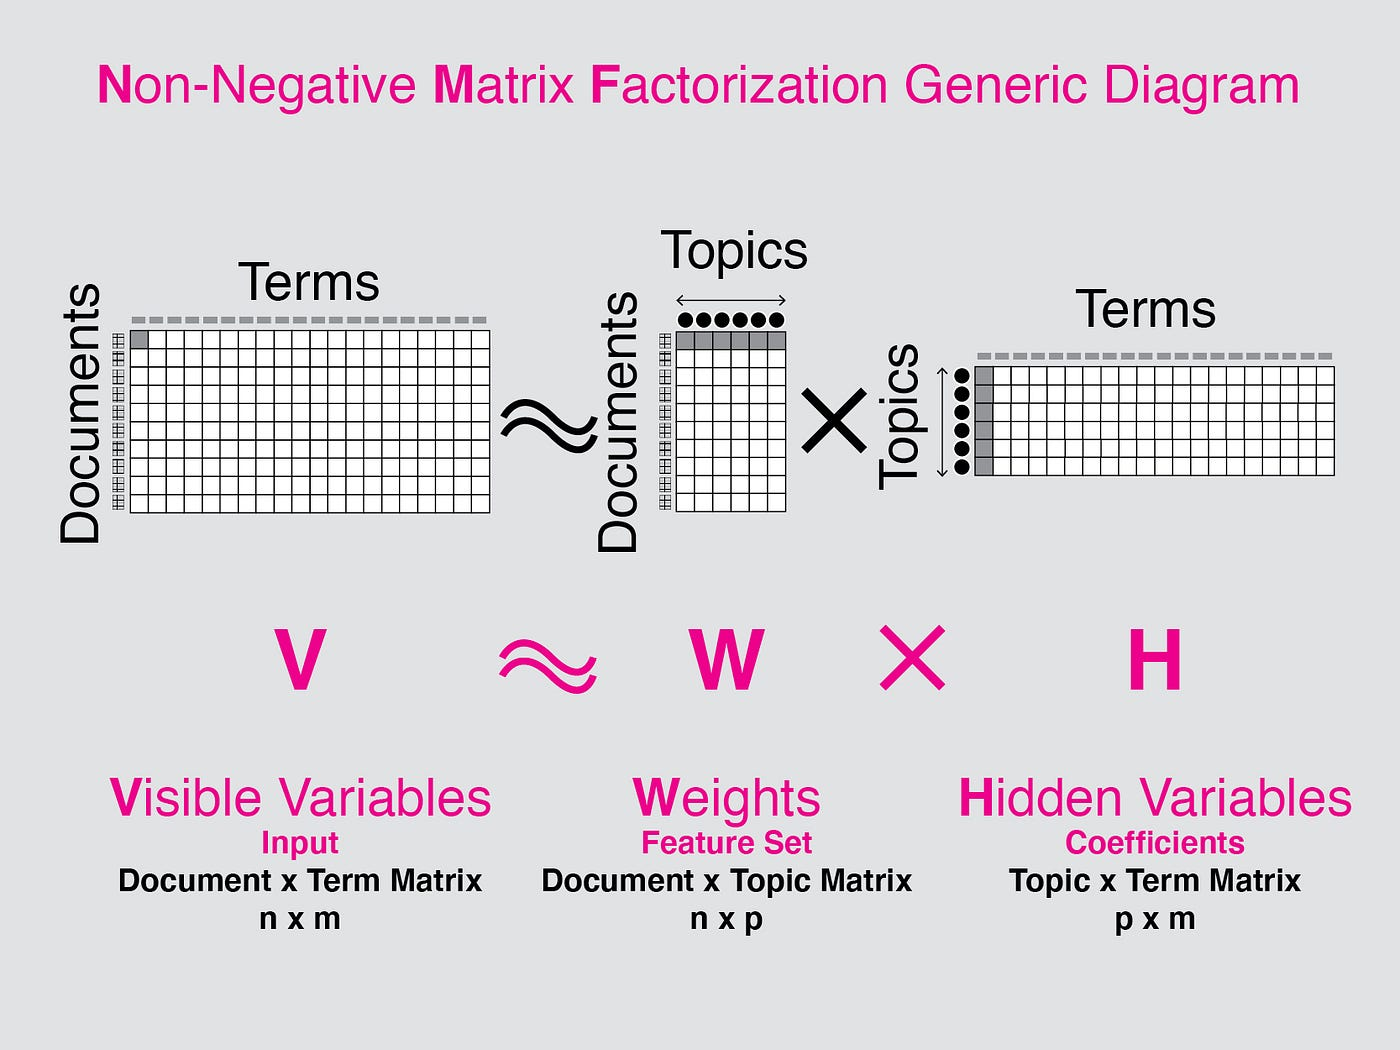

We're going to approximate each object (i.e. column of $A$) by a linear combination of $k$ reduced dimensions of "basis vectors" in $W$. Each basis vector can be interpreted as a cluster. The membership of objects in these clusters encoded by $H$.

The way it's going to work is that we have an input: non-negatrive matrix ($A$), number of basis vectors ($k$), initial values for factors $W$ and $H$ (e.g. random matrices).

Objective Function: Some measure of recontruction error between $A$ and the approximation $WH$.
<br></br>
<center>$\frac{1}{2} ||A - WH||_{F}^2 = \sum_{n=1}^{n} \sum_{j=1}^{m}(A_{ij} - (WH)_{ij})^2 $</center>
<br></br>
And then what we're going to to is to optimizr. So we have expectation-maximization optimisation to refine $W$ and $H$ in order to minimise the objective function. Common approach is to iterate between two multiplicative update rules until convergence.

1. Update $H$
<br></br>
$H_{cj} \leftarrow H_{cj} \frac{(W\textbf{A})_{cj}}{(W\textbf{WH})_{cj}}$
<br></br>
2. Update $W$
<br></br>
$W_{cj} \leftarrow W_{cj} \frac{(\textbf{A}H)_{cj}}{(\textbf{WH}H)_{cj}}$
<br></br>

The way it works for this particular usecase is that:

1. Construct vector space model for documents (after stopword filtering), resulting in a term-document matrix $A$.
2. Apply TF-IDF term weight numalisation to $A$.
3. Normalize TF-IDF vectors to unit length.
4. Initialise factors using NNDSVD (non-negative double singular value decomposition) on $A$.
5. Apply projected Gradient NMF to $A$.

Basis vectors: the topics (clusters) in the data. Coefficient matrix: the membership weights for documents relative to each topic (cluster).

Just like LDA, we will need to select the number of expected topics beforehand (the value of $k$). Also just like with LDA we will have to interpret the topics based off the coefficient values of the words per topic.

In [49]:
import pandas as pd

In [50]:
npr = pd.read_csv('npr.csv')

## Preprocessing

We need to change preprocessing feature extraction because of LDA's dependence on per-word count probabilities with Dirichlet probability distrinbution, we could only use count vectorizers for LDA. But since non-negative matrix factorization works of coefficient values, here, we can pre-process the text with TF-IDF vectorization.

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [52]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [53]:
dtm = tfidf.fit_transform(npr['Article'])

It is a sparse matrix just like before.

In [54]:
dtm

<11992x54777 sparse matrix of type '<class 'numpy.float64'>'
	with 3033388 stored elements in Compressed Sparse Row format>

## NMF model

Now to perfom NMF we simply use `scikit-learn`.

In [55]:
from sklearn.decomposition import NMF

In [56]:
nmf_model = NMF(n_components=7, random_state=42)

In [57]:
%%time
nmf_model.fit(dtm)

Wall time: 6.59 s


NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=7, random_state=42, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)

Let's display the topics.

In [59]:
tfidf.get_feature_names()[2300]

'albala'

In [60]:
for index, topic in enumerate(nmf_model.components_):
    print(f"THE TOP 15 WORDS FOR TOPIC #{index}")
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['new', 'research', 'like', 'patients', 'health', 'disease', 'percent', 'women', 'virus', 'study', 'water', 'food', 'people', 'zika', 'says']


THE TOP 15 WORDS FOR TOPIC #1
['gop', 'pence', 'presidential', 'russia', 'administration', 'election', 'republican', 'obama', 'white', 'house', 'donald', 'campaign', 'said', 'president', 'trump']


THE TOP 15 WORDS FOR TOPIC #2
['senate', 'house', 'people', 'act', 'law', 'tax', 'plan', 'republicans', 'affordable', 'obamacare', 'coverage', 'medicaid', 'insurance', 'care', 'health']


THE TOP 15 WORDS FOR TOPIC #3
['officers', 'syria', 'security', 'department', 'law', 'isis', 'russia', 'government', 'state', 'attack', 'president', 'reports', 'court', 'said', 'police']


THE TOP 15 WORDS FOR TOPIC #4
['primary', 'cruz', 'election', 'democrats', 'percent', 'party', 'delegates', 'vote', 'state', 'democratic', 'hillary', 'campaign', 'voters', 'sanders', 'clinton']


THE TOP 15 WORDS FOR TOPIC #5
['love', 've', 'don', 'al

Let's assign this topics to the articles.

In [61]:
topic_results = nmf_model.transform(dtm)

If we grab a value for a topic result it is a coefficient values for the top topic that's representative.

In [62]:
topic_results[0]

array([0.        , 0.12075603, 0.00140297, 0.05919954, 0.01518909,
       0.        , 0.        ])

In [63]:
topic_results[0].argmax()

1

In [64]:
topic_results.argmax(axis=1)

array([1, 1, 1, ..., 0, 4, 3], dtype=int64)

In [65]:
npr['Topic'] = topic_results.argmax(axis=1)

The numbers are don't really mean anything. What means are words assigned for a certain topic.

In [66]:
npr.head(8)

,Article,Topic
0,"In the Washington of 2016, even when the polic...",1
1,Donald Trump has used Twitter — his prefe...,1
2,Donald Trump is unabashedly praising Russian...,1
3,"Updated at 2:50 p. m. ET, Russian President Vl...",3
4,"From photography, illustration and video, to d...",6
5,I did not want to join yoga class. I hated tho...,5
6,With a who has publicly supported the debunk...,0
7,"I was standing by the airport exit, debating w...",0


In [70]:
mytopic_dict = {0: 'Health', 1: 'Politics', 2: 'Legis', 3: 'Politics', 4: 'Election', 5: 'Music', 6: 'Education'}

npr['Topic Label'] = npr['Topic'].map(mytopic_dict)

In [71]:
npr.head()

,Article,Topic,Topic Label
0,"In the Washington of 2016, even when the polic...",1,Politics
1,Donald Trump has used Twitter — his prefe...,1,Politics
2,Donald Trump is unabashedly praising Russian...,1,Politics
3,"Updated at 2:50 p. m. ET, Russian President Vl...",3,Politics
4,"From photography, illustration and video, to d...",6,Education
